In [16]:
base_data_path = "data/embeddings/"

In [2]:
!ls data/embeddings

test_dataset00.pth  train_dataset00.pth  val_dataset00.pth
test_dataset01.pth  train_dataset01.pth  val_dataset01.pth


In [17]:
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

In [ ]:
# class EmbeddingDataset(Dataset):
#     def __init__(self, embeddings, labels):
#         # embeddings: list of numpy arrays or torch tensors
#         # labels: list of scalars
#         self.X = torch.tensor(embeddings, dtype=torch.float32)
#         self.y = torch.tensor(labels, dtype=torch.float16)  # or long, depending on your task
# 
#     def __len__(self):
#         return len(self.y)
# 
#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

In [18]:
# class EssayScoreDataset(Dataset):
#     def __init__(self, X, y):
#         """
#         Args:
#             X (list or array-like): Feature data.
#             y (list or array-like): Essay scores (integers from 0 to 60).
#         """
#         self.X = X
#         self.y = y
# 
#     def __len__(self):
#         return len(self.X)
# 
#     def __getitem__(self, idx):
#         x = torch.tensor(self.X[idx], dtype=torch.float32)  # Input features as float32
#         y = torch.tensor(self.y[idx], dtype=torch.float16)  # Scores as float16
#         return x, y


class EssayScoreDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (list, array-like, or ndarray): Feature data.
            y (list or array-like): Essay scores (integers from 0 to 60).
        """
        # Convert X to a tensor if it's not already
        self.X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        # Convert y to a tensor
        self.y = torch.tensor(y, dtype=torch.float32) if not isinstance(y, torch.Tensor) else y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # Already a tensor
        y = self.y[idx]  # Already a tensor
        return x, y


In [19]:
training_dataset = torch.load("data/embeddings/train_dataset01.pth")
testing_dataset = torch.load("data/embeddings/test_dataset01.pth")
val_dataset = torch.load("data/embeddings/val_dataset01.pth")

/tmp/ipykernel_30728/2349267412.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset = torch.load("data/embeddings/train_dataset01.pth")
/tmp/ipykernel_30728

In [20]:
len(val_dataset), len(testing_dataset), len(training_dataset)

(622, 1952, 10403)

In [21]:
# # Convert dataset outcomes to float32
# def convert_dataset_to_float32(dataset):
#     dataset.y = dataset.y.to(torch.float32)
#     return dataset

def convert_dataset_to_float32(dataset):
    # Ensure y is converted to a PyTorch tensor first
    if isinstance(dataset.y, list):
        dataset.y = torch.tensor(dataset.y, dtype=torch.float32)
    else:
        dataset.y = dataset.y.to(torch.float32)
    return dataset

# Convert all datasets
training_dataset = convert_dataset_to_float32(training_dataset)
testing_dataset = convert_dataset_to_float32(testing_dataset)
val_dataset = convert_dataset_to_float32(val_dataset)


In [22]:
training_dataset.X = torch.tensor(training_dataset.X, dtype=torch.float32)
testing_dataset.X = torch.tensor(testing_dataset.X, dtype=torch.float32)
val_dataset.X = torch.tensor(val_dataset.X, dtype=torch.float32)

In [23]:
type(training_dataset.X)

torch.Tensor

In [24]:
# Define a simple two-layer neural net with dropout and layer norm
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x


In [25]:
input_dim = int(testing_dataset.X[0].shape[0])
hidden_dim = int(testing_dataset.X[0].shape[0]/2)

In [35]:
model = SimpleNeuralNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
model = model.to("cuda")

In [36]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

In [39]:
num_epochs = 10

In [40]:
# Prepare data loaders
batch_size = 512
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)


In [41]:
train_losses = []
test_losses = []

for epoch_num in range(num_epochs):
    
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(-1), labels)
            # test_loss += loss.item()
            test_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
        avg_loss = test_loss/len(testing_dataset)
        test_losses.append(avg_loss)
        print(f"TEST LOSS: PRE Epoch-{epoch_num}, we have {avg_loss:.4f}")
        

    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch_num}"):
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # loss = criterion(outputs, labels) # MY MSITAKE - DO NOT DO THIS
        loss = criterion(outputs.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # train_loss += loss.item()
        train_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = train_loss/len(training_dataset) # /len(train_dataset) ?? TODO
    train_losses.append(avg_loss)  
    print(f"TRAIN LOSS: On Epoch-{epoch_num}, we have {avg_loss:.4f}")
        
        

TEST LOSS: PRE Epoch-0, we have 121.9037


Training Epoch 0:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-0, we have 77.0136
TEST LOSS: PRE Epoch-1, we have 59.2804


Training Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-1, we have 47.7096
TEST LOSS: PRE Epoch-2, we have 30.8219


Training Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-2, we have 27.0455
TEST LOSS: PRE Epoch-3, we have 19.1743


Training Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-3, we have 17.1422
TEST LOSS: PRE Epoch-4, we have 12.2894


Training Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-4, we have 11.4667
TEST LOSS: PRE Epoch-5, we have 8.5828


Training Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-5, we have 8.0908
TEST LOSS: PRE Epoch-6, we have 6.1475


Training Epoch 6:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-6, we have 6.2343
TEST LOSS: PRE Epoch-7, we have 5.3008


Training Epoch 7:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-7, we have 5.1234
TEST LOSS: PRE Epoch-8, we have 4.6560


Training Epoch 8:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-8, we have 4.7508
TEST LOSS: PRE Epoch-9, we have 4.7887


Training Epoch 9:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-9, we have 4.6525


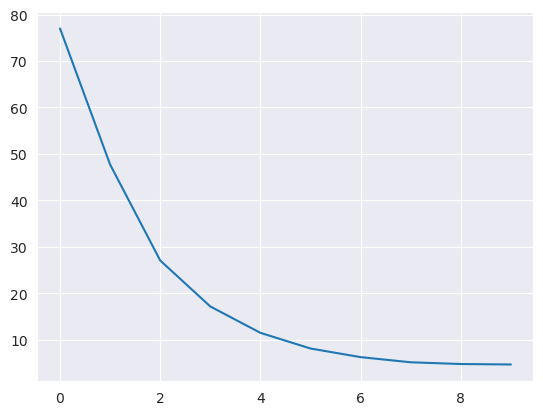

In [42]:
plt.plot(train_losses)

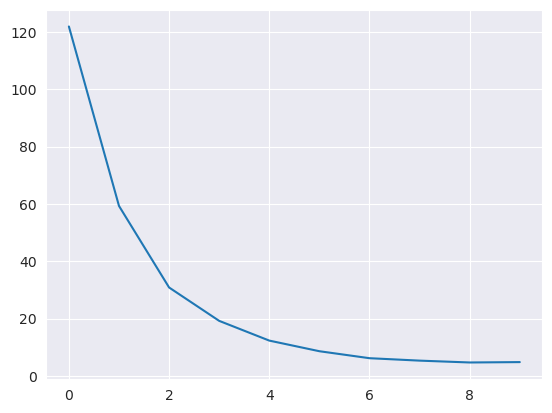

In [43]:
plt.plot(test_losses)

In [44]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [45]:
val_loss = 0.0
model.eval()
with torch.no_grad():
    # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(-1), labels)
        # test_loss += loss.item()
        val_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = val_loss/len(testing_dataset)
    print(f"ON VAL SET, ACHIEVED {avg_loss:.4f}")

ON VAL SET, ACHIEVED 4.3386


In [ ]:
# Define the train function for 1 epoch
def train_one_epoch(model, dataloader, optimizer, device, epoch):


In [ ]:
# Define the evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(dataloader, desc="Evaluating")):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Validation Loss = {avg_loss:.4f}")
    return avg_loss



In [ ]:
input_dim = training_dataset.X.shape[1]
hidden_dim = 512
output_dim = 1




In [ ]:
optimizer = get_optimizer(model, learning_rate=0.001)

In [ ]:
# Train and evaluate
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, train_loader, optimizer, device, epoch)
    eval_loss = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}: Validation Loss = {eval_loss:.4f}")